# Step 2 — Complementary Movement

## **Goal**
Build on Step 1 by adding a “backup rule” so that when an agent fails the threshold rule,  
they can still move toward a complementary (different) neighbor before staying or moving to random.

---

## **Key Additions from Step 1**
- **anti-backtrack**: prevent unrealistic ping-pong movement between two nodes, stabilizing the diffusion and making footfall patterns more realistic  
- Add **p_move_below**: if threshold not met, move to different-category node with this probability.  
- Define a clear **stay condition**: if both fail, agent stays or makes a minimal random move within its neighbors.  
- Anchor remains fixed (e.g., node 0) to ensure consistent diffusion tracking.

---

## **Movement Logic Summary**
| Step | Condition | Action |
|------|------------|--------|
| ① | `ratio_same ≥ θ_same` | Move to a *similar* neighbor |
| ② | `ratio_same < θ_same` and random < `p_move_below` | Move to a *different* neighbor (backup rule) |
| ③ | Otherwise | Stay (or random minimal move) |

---

## **Parameter Settings**
| Parameter | Meaning | Example |
|------------|----------|----------|
| `θ_same` | Same-category ratio threshold | 0.6 |
| `p_move_below` | Probability of moving to different node below threshold | 0.4 |
| `p_stay_anchor` | Probability of staying at anchor | 0.3 |
| `steps` | Number of time ticks | 10 |
| `n_agents` | Number of customers | 100 |

---

## **Interpretation**
- When **θ_same ↑**, agents cluster near similar stores.  
- When **p_move_below ↑**, diffusion toward other categories increases.  
- Fixed anchor allows consistent measurement of footfall spread and spillover effects.

---

In [13]:
import sys, os
PROJECT_ROOT = os.path.abspath("..")  
sys.path.append(PROJECT_ROOT)
sys.path.append(os.path.join(PROJECT_ROOT, "src"))

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
from src.asm.simulate_step2 import Params, simulate, animate_movement
from utils.io import ensure_dir  

p = Params(theta_same=0.6, p_move_below=0.5, p_stay_anchor=0.2, steps=50, n_agents=200, count_t0=True)

df, sim, A0 = simulate(p)
print("Anchor fixed at node:", A0)

expected = p.n_agents * (p.steps + int(p.count_t0))
print(f"Total={df.footfall.sum()} | Expected={expected}")

[Saved] data/outputs/step2_visible.csv
Anchor fixed at node: 0
Total=10200 | Expected=10200


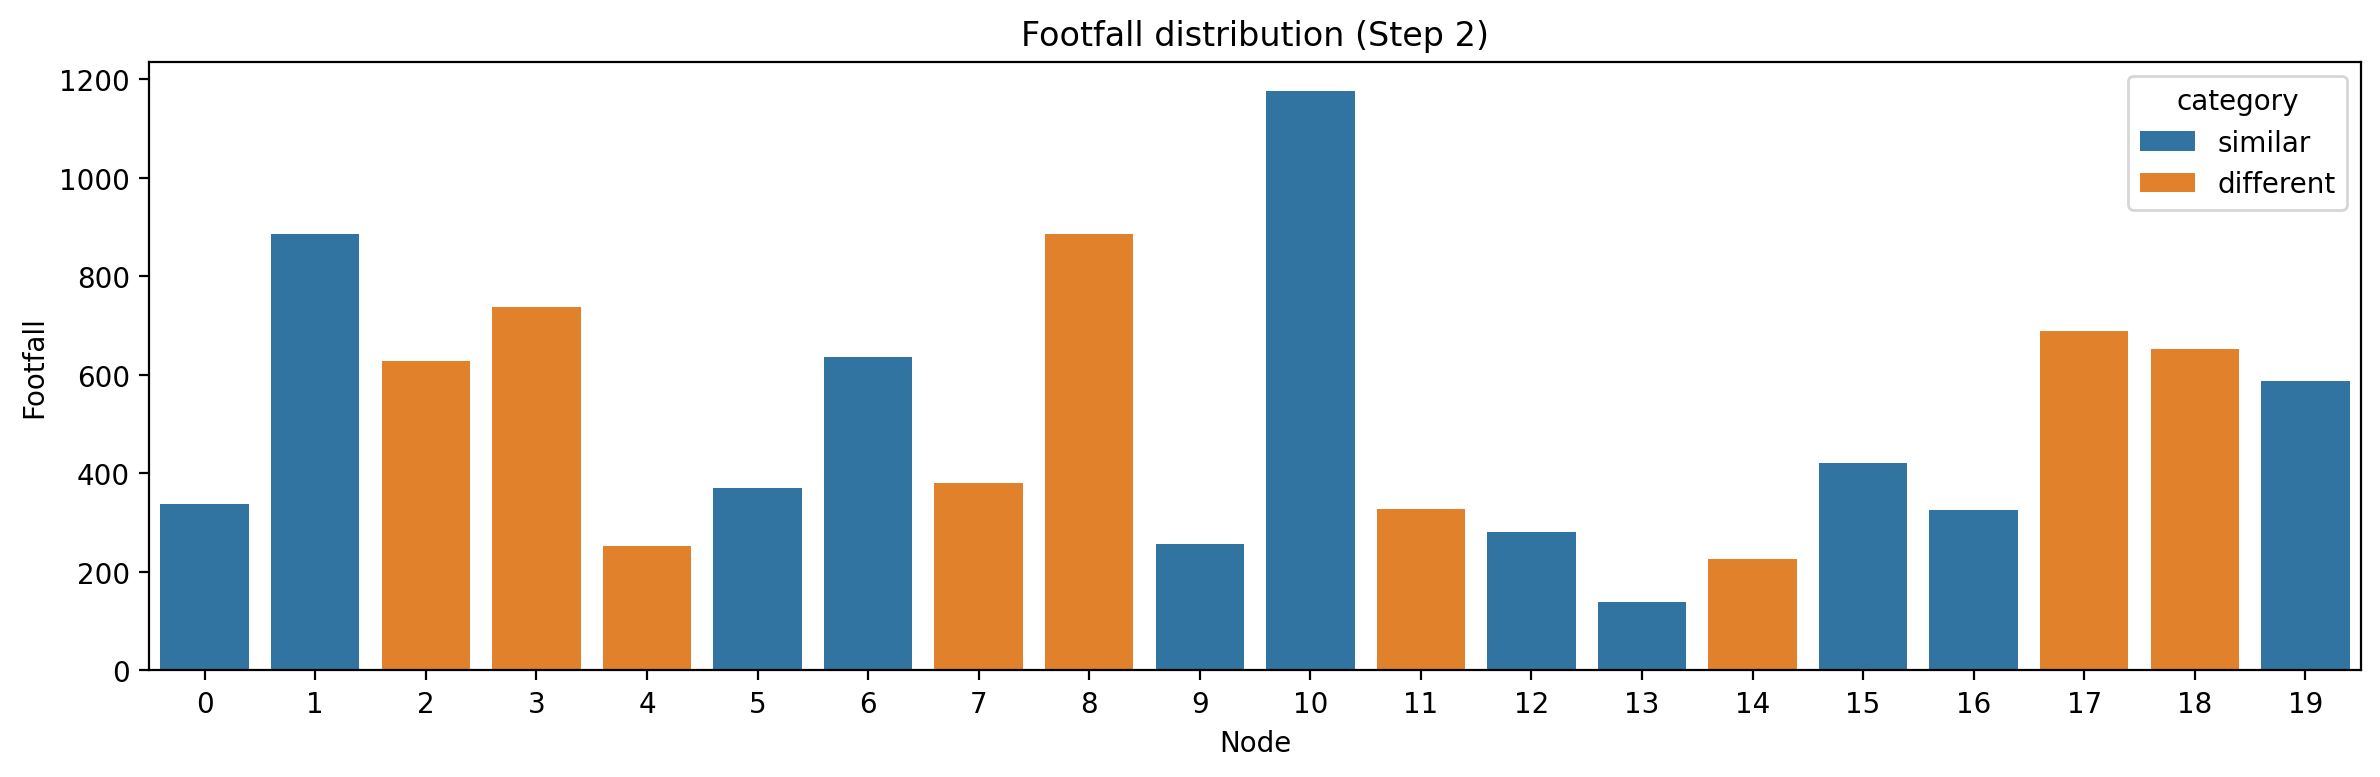

In [15]:
import matplotlib.pyplot as plt, seaborn as sns

plt.figure(figsize=(12,4))
sns.barplot(data=df.sort_values("node"), x="node", y="footfall", hue="category")
plt.title("Footfall distribution (Step 2)")
plt.xlabel("Node"); plt.ylabel("Footfall")
plt.tight_layout()
plt.show()

[Saved GIF] figs/step2_visible.gif


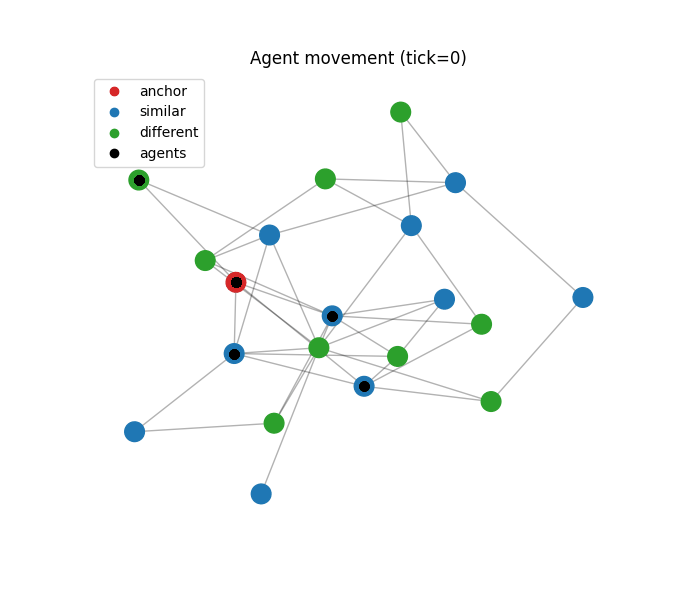

In [16]:
from IPython.display import Image, display

ensure_dir("figs")
out_path = "figs/step2_visible.gif"
animate_movement(sim, filename=out_path, interval=p.interval_ms)  # 모듈 함수 그대로 사용
display(Image(filename=out_path))  # 노트북에 바로 표시


In [17]:
import pandas as pd
summary = pd.DataFrame({
    'metric':['total','anchor_total','anchor_share','similar_total','different_total'],
    'value':[df.footfall.sum(),
             df.query("role=='anchor'").footfall.sum(),
             df.query("role=='anchor'").footfall.sum()/df.footfall.sum(),
             df.query("category=='similar'").footfall.sum(),
             df.query("category=='different'").footfall.sum()]
})
summary


,metric,value
0,total,10200.000000
1,anchor_total,337.000000
2,anchor_share,0.033039
3,similar_total,5418.000000
4,different_total,4782.000000


## **Step 2 — Interpretation & Summary**

### **Observations**

| Aspect | Observation | Interpretation |
|:--|:--|:--|
| **Footfall distribution** | Visits are still concentrated around a handful of key nodes (e.g., 10, 8, 1, 3) but traffic is more evenly spread around the network. | The previous over-concentration at the anchor has been relieved. |
| **Anchor (node 0)** | Medium-level foot traffic — anchor still attracts but with diffusion | With `p_stay_anchor = 0.2`, agents remain in one place and wander around |
| **Similar vs Different** | Similar nodes continue to dominate, but traffic on dissimilar nodes rises significantly | `θ_same = 0.6` and `p_move_below = 0.5` preserve clustering with the re-emergence of complementary diffusion |
| **Agent movement (GIF)** | AAgents begin to cluster near the anchor, gradually propagating slowly to green (alternative) nodes | omplementary movement is initiated and anti-backtrack stabilizes routes |

---

### **Interpretation**

- The interaction of **threshold** and **complementary-movement rules** shifts the system
  away from an entirely anchor-focused pattern to a **balanced diffusion model**.
- **Anti-backtrack** removes unrealistic flip-flopping between two nodes
leading to smoother and more authentic footfall patterns across the network.
- Overall, Step 2 achieves both **functional diffusion** and **social clustering**,
improving behavioral realism compared to Step 1.

---

## **Step 2 vs Step 3 — Comparative Insights**

| Dimension | **Step 2 – Complement Rule** | **Step 3 – Visibility / Attractiveness** |
|:--|:--|:--|
| **Logic center** | Threshold + Complementary + Anti-backtrack | Threshold + Spatial Visibility / Distance Weight |
| **Model emphasis** | Behavioral realism ↑ – recovering mobility | Spatial realism ↑ – responding to store layout & distance |
| **Pattern of footfall** | Balanced diffusion around the anchor | Re-concentration into key "hot-spot" areas
| **Managerial insight** | Increases anchor - complementary store linkage → increased dwell time | Leverages visibility / positioning to focus strategic traffic most efficiently |
| **Analytical perspective** | "Behavior-based" simulation | "Behavior + Space" combined model |


---

## **Managerial Insight**

- Step 2 incorporates behavioral flexibility, providing a more realistic customer flow within the mall.
- With Step 3 contributing **spatial factors** such as visibility and distance,
it supports quantitative analysis of **anchor effects**, **zone attractiveness**,  
and **layout-based traffic optimization**.